# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib_venn import venn3, venn2
import random
import plotly.io as pio
from scipy import sparse
import os 

In [2]:
seed = 16
random.seed(seed)
np.random.seed(seed)

#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
#plt.rcParams['axes.facecolor'] = 'white'
#plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

sns.set_style("darkgrid", rc={'xtick.bottom': True})

In [3]:
data_processed = "../../../data/processed/"
data_interim = "../../../data/interim/"
data_external = "../../../data/external/"
graph_data = data_processed + "graph_data_nohubs/"
reports_tfidf = "../../../reports/reports_nohubs/analisis_tfidf/"

graph_node_data = pd.read_csv(graph_data+"nohub_graph_node_data.csv")
graph_edge_data = pd.read_csv(graph_data+"nohub_graph_edge_data.csv").rename(columns={"relation":"edge_type"})

disease_attributes = pd.read_csv(graph_data+"nohub_disease_attributes.csv")

#agrego los nodos bert al df de disease attributes (aunque no tienen atributos)
nodos_bert = graph_node_data.loc[graph_node_data.node_type == "bert_group",["node_index","node_id","node_name","node_source"]].copy()
disease_attributes = pd.concat([disease_attributes,nodos_bert])

enfermedades_en_dd = graph_node_data.loc[graph_node_data.degree_dd != 0, "node_index"].values

#me quedo solo con las enfermedades que están en DD
disease_attributes = disease_attributes.set_index("node_index").loc[enfermedades_en_dd].reset_index()

disease_attributes = pd.merge(graph_node_data[["node_index","comunidades_infomap","comunidades_louvain"]],disease_attributes,left_on="node_index",right_on="node_index",how="right")

In [4]:
tamaños_louvain = disease_attributes.comunidades_louvain.value_counts()
tamaños_infomap = disease_attributes.comunidades_infomap.value_counts()

infomap_clusters = pd.DataFrame(tamaños_infomap).reset_index().rename(columns={"index":"comunidad","comunidades_infomap":"tamaño"}).astype({"comunidad":"int"})
louvain_clusters = pd.DataFrame(tamaños_louvain).reset_index().rename(columns={"index":"comunidad","comunidades_louvain":"tamaño"}).astype({"comunidad":"int"})

In [5]:
def load_sparse_dataframe(matrix_path,row_path,column_path):
    mat = sparse.load_npz(matrix_path)
    row = np.loadtxt(row_path)
    col = np.loadtxt(column_path, dtype="str")
    df = pd.DataFrame.sparse.from_spmatrix(mat, index=row, columns=col)
    return df

In [6]:
# path = data_processed + "tfidf_nodos/"
# monogram_dtm = load_sparse_dataframe(path+"matriz_nodos_tfidf_0.npz",path+"rows_tfidf_nodos_0.txt",path+"cols_tfidf_nodos_0.txt")
# bigram_dtm = load_sparse_dataframe(path+"matriz_nodos_tfidf_1.npz",path+"rows_tfidf_nodos_2.txt",path+"cols_tfidf_nodos_3.txt")

In [ ]:
# pd.to_pickle(infomap_clusters,tfidf_reports+"infomap_analysis_checkpoint.pkl")
# pd.to_pickle(louvain_clusters,tfidf_reports+"louvain_analysis_checkpoint.pkl")

In [44]:
# analysis_infomap = pd.read_pickle("../../../reports/tfidf/infomap_analysis_checkpoint.pkl")
# analysis_louvain = pd.read_pickle("../../../reports/tfidf/louvain_analysis_checkpoint.pkl")

# path = data_processed + "tfidf_infomap/"
# path_louvain = data_processed + "tfidf_louvain/"
# monograms_infomap = load_sparse_dataframe(path + "matriz_tfidf_infomap_0.npz",path + "rows_tfidf_infomap_0.txt", path+"cols_tfidf_infomap_0.txt")
# monograms_louvain = load_sparse_dataframe(path_louvain + "matriz_tfidf_louvain_0.npz",path_louvain + "rows_tfidf_louvain_0.txt", path_louvain+"cols_tfidf_louvain_0.txt")
# bigrams_infomap = load_sparse_dataframe(path + "matriz_tfidf_infomap_1.npz",path + "rows_tfidf_infomap_1.txt", path+"cols_tfidf_infomap_1.txt")
# trigrams_infomap = load_sparse_dataframe(path + "matriz_tfidf_infomap_2.npz",path + "rows_tfidf_infomap_2.txt", path+"cols_tfidf_infomap_2.txt")

# Exploro los datos

Ver cuantos nans tengo en total, cuantos por cada categoría.

Ver la longitud del texto de cada enfermedad (en tokens, no chars)

Ver de agregarle attr a los berts? Verificar si suelen tener tfidf bajo respecto a los demás


In [10]:
def quick_venn(item_list,set_names=None):
    plt.figure()
    venn_length = len(item_list)
    if venn_length == 2:
        s1 = set(item_list[0])
        s2 = set(item_list[1])
        v = venn2([s1,s2],set_names)
    if venn_length == 3:
        s1 = set(item_list[0])
        s2 = set(item_list[1])
        s3 = set(item_list[2])
        v = venn3([s1,s2,s3],set_names)

## Veo cobertura de datos

Nan counts para descripciones, según fuente:

False    9854
True     2514
Name: mondo_definition, dtype: int64
True     8417
False    3951
Name: orphanet_definition, dtype: int64
False    8325
True     4043
Name: umls_description, dtype: int64


Text(0.5, 1.0, 'De los nodos sin descripción, cuantos son Berts?')

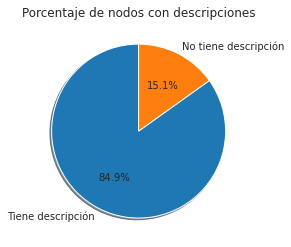

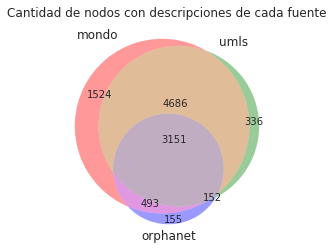

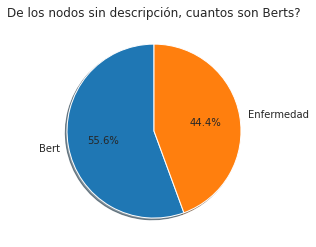

In [11]:
print("Nan counts para descripciones, según fuente:\n")
print(disease_attributes.mondo_definition.isna().value_counts())
print(disease_attributes.orphanet_definition.isna().value_counts())
print(disease_attributes.umls_description.isna().value_counts())

#all_cuis = set(disease_attributes.node_id.values)
mondo = set(disease_attributes[~disease_attributes.mondo_definition.isna()].node_id.values)
umls = set(disease_attributes[~disease_attributes.umls_description.isna()].node_id.values)
orphanet = set(disease_attributes[~disease_attributes.orphanet_definition.isna()].node_id.values)

no_desc = disease_attributes[(disease_attributes.mondo_definition.isna()) & (disease_attributes.umls_description.isna()) & (disease_attributes.orphanet_definition.isna())]
has_desc = disease_attributes[(~disease_attributes.mondo_definition.isna()) | (~disease_attributes.umls_description.isna()) | (~disease_attributes.orphanet_definition.isna())]

fig, ax = plt.subplots()
ax.pie([len(has_desc),len(no_desc)], labels=["Tiene descripción","No tiene descripción"], autopct='%1.1f%%',shadow=True, startangle=90)
# ax.axis('equal') 
ax.set_title("Porcentaje de nodos con descripciones")


quick_venn([mondo,umls,orphanet],["mondo","umls","orphanet"])
plt.title("Cantidad de nodos con descripciones de cada fuente")


fig, ax = plt.subplots()
ax.pie([len(no_desc[no_desc.node_source == "primekg"]),len(no_desc) - len(no_desc[no_desc.node_source == "primekg"])], labels=["Bert","Enfermedad"], autopct='%1.1f%%',shadow=True, startangle=90)
# ax.axis('equal') 
ax.set_title("De los nodos sin descripción, cuantos son Berts?")

Considerar agregar descripciones agrupadas a los grupos bert, esto va a "forzar" la similaridad pero creo que está bien que eso pase.

## Describo los datos

Algunas features están repetidas, esto es porque unas ontologías son más amplias que otras, entonces puede que distintos nodos tengan la misma definición en una ontología.

Las repeticiones deberían tender a agrupar juntos a esos nodos con tf-idf, pero está bien, por que **sabemos** que esos nodos **son** similares.

In [12]:
umls_repetido = len(disease_attributes[disease_attributes.umls_description.duplicated(keep=False)].dropna().sort_values(by="umls_description"))
mondo_repetido = len(disease_attributes[disease_attributes.mondo_definition.duplicated(keep=False)].dropna().sort_values(by="mondo_definition"))
orphanet_repetido = len(disease_attributes[disease_attributes.orphanet_definition.duplicated(keep=False)].dropna().sort_values(by="orphanet_definition"))

todas_repetidas = disease_attributes.dropna().duplicated(subset=["umls_description","mondo_definition","orphanet_definition"]).value_counts()[1]

display(pd.DataFrame.from_dict({"UMLS duplicada":umls_repetido, "MONDO duplicada":mondo_repetido,"Orphanet_repetido":orphanet_repetido,"Todas repetidas":todas_repetidas},orient="index").rename(columns={0:"Count"}))

,Count
UMLS duplicada,1217
MONDO duplicada,1102
Orphanet_repetido,1104
Todas repetidas,531


In [13]:
desc_cols = ["mondo_definition","umls_description","orphanet_definition"]

Las descripciones de UMLS tienden a ser más largas, esto es porque "colapsé" las definiciones diferentes que tenían en una sola. Voy a normalizar los vectores tf-idf para que esto no moleste.

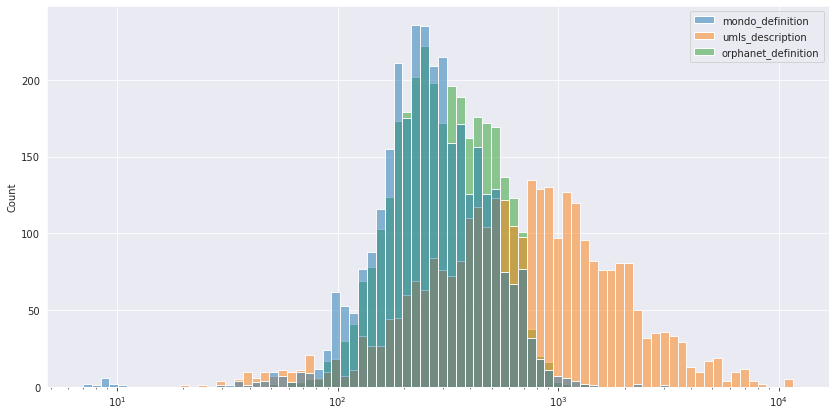

In [14]:
desc_lengths = disease_attributes[desc_cols].dropna().applymap(lambda x: len(x))

fig, ax = plt.subplots(figsize=(14,7))
plot = sns.histplot(data=desc_lengths, log_scale=True,ax=ax)

# Vectorización TF-IDF

In [12]:
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

custom_stopwords = ["disease","syndrome","congenital","disorder","type","association","abnormality","include","omim","nih","hpo","characterize","pmid","24h","1st","2nd","3rd","i","ii","iii","iv","v","vi","vii","viii","ix"]
stop_words = text.ENGLISH_STOP_WORDS.union(custom_stopwords)

## Preprocessing
Armado del corpus y el "documento" de cada cluster y preprocesado de texto. 

In [13]:
import regex as re

def remove_symbols(data):
    symbols = "!-.\"\'#$%&()*+/:;<=>?@[\]^_`{|}°,~\n"
    for i in symbols:
        data = np.char.replace(data, i, ' ')
    return data

def remove_numbers(text,any_number,whitespace):
    if any_number:
        text = re.sub(r'\d+', '', text)
    if whitespace:
        text = re.sub(r'\b(\d+)\b', '', text)
    return text

def more_regex_cleaning(text):
    patterns = [r'(\d+)hr',r'(\d+)th',r'(\d+)cm',r'(\d+)mm',r'(\d+)mmhg',r'\b[1-9][a-zA-Z]\b',r'\b[a-zA-Z][1-9]\b',r'(\d+)a',r'(\d+)b',r'(\d+)c']
    for pattern in patterns:
        text = re.sub(pattern, "", text)
    return text

lemmatizer = WordNetLemmatizer()
# def filter_plurals(lemmatizer, text):
#     words = text.split()
#     new_text = ""
#     for word in words :
#         lem = lemmatizer.lemmatize(word)
#         new_text += " " + lem
#     return new_text

def getWordNetPOS(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tagDict = {"J": wordnet.ADJ,
    "N": wordnet.NOUN,
    "V": wordnet.VERB,
    "R": wordnet.ADV}
    return tagDict.get(tag, wordnet.NOUN)

def lemmatize_text(lemmatizer,text):
    words = text.split()
    new_text = ""
    tags = [getWordNetPOS(word) for word in words]
    for word,tag in zip(words,tags):
        lem = lemmatizer.lemmatize(word,pos=tag)
        new_text += " " + lem 
    return new_text

def filter_stopwords(text):
    new_text = ""
    words = text.split()
    for word in words:
        if word not in stop_words:
            new_text = new_text + " " + word
    return new_text

def preprocess(corpus,lemmatizer,lemma_filter,remove_stopwords=True,sub_numbers=False,regex_clean=True):
    corpus = np.char.lower(corpus)
    corpus = remove_symbols(corpus)
    if remove_stopwords:
        corpus = np.array([filter_stopwords(text) for text in corpus]).astype(str)
    if lemma_filter:
        corpus = np.array([lemmatize_text(lemmatizer,text) for text in corpus]).astype(str)
    if sub_numbers:
        corpus = np.array([remove_numbers(text,any_number=False,whitespace=True) for text in corpus]).astype(str)
    if regex_clean:
        corpus = np.array([more_regex_cleaning(text) for text in corpus]).astype(str)
    if remove_stopwords:
        corpus = np.array([filter_stopwords(text) for text in corpus]).astype(str)

    return corpus


def node_as_document(node_index,df,lemmatizer,lemma_filter=True,remove_stopwords=True,sub_numbers=True,join_titles=True):
    data = df.loc[df["node_index"] == node_index, ["node_name","mondo_definition","umls_description","orphanet_definition"]].values.astype(str)
    data = np.delete(data,np.where(data[0] == "nan"))
    data = preprocess(data,lemmatizer,lemma_filter,remove_stopwords,sub_numbers)
    if join_titles:
        document = " ".join(data)
        document = document + " "
        document = document.replace(". ", " ")
    else:
        document = data
    return document


def node_name_as_document(node_index,df,lemmatizer,lemma_filter=True,remove_stopwords=True,sub_numbers=True,join_titles=True):
    data = df.loc[df["node_index"] == node_index, "node_name"].values.astype(str)
    data = preprocess(data,lemmatizer,lemma_filter,remove_stopwords,sub_numbers)
    if join_titles:
        document = " ".join(data)
        document = document + " "
        document = document.replace(". ", " ")
    else:
        document = data
    return document


def get_tfidf_df(vectorizer,corpus,ids,df=True):
    X = vectorizer.fit_transform(corpus)
    if df:
        #X = pd.DataFrame(X.toarray(), index=ids, columns=vectorizer.get_feature_names_out())
        X = pd.DataFrame.sparse.from_spmatrix(X, index=ids, columns=vectorizer.get_feature_names_out())
    return X

def tfidf_similarity(vectorizer,corpus,ids,df=True):
    scores = get_tfidf_df(vectorizer,corpus,ids,False)
    similarity_matrix = cosine_similarity(scores,scores,False)
    if df:
        similarity_matrix = pd.DataFrame.sparse.from_spmatrix(similarity_matrix, index=ids, columns=ids)
    return similarity_matrix

Ejemplo de preprocesado:

In [29]:
has_desc = disease_attributes[(~disease_attributes.mondo_definition.isna()) | (~disease_attributes.umls_description.isna()) | (~disease_attributes.orphanet_definition.isna())]
node_index = has_desc.sample(1).node_index.values[0]
node_info = disease_attributes.loc[disease_attributes.node_index == node_index, ["node_name","mondo_definition","umls_description","orphanet_definition"]].values
print(f"Antes de preprocessing:\n {node_info}\n")
print("Después de preprocessing:")
node_as_document(node_index,disease_attributes,lemmatizer,sub_numbers=True)

Antes de preprocessing:
 [['Branchial Clefts-Congenital disorder'
  'A congenital defect in the neck that occurs during early embryonic development. It is caused by developmental abnormalities of the pharyngeal arches and results in the development of a cyst or a fissure in the side of the neck.'
  'A branchial cyst is a remnant of embryonic development resulting from a failure of obliteration of a branchial cleft and consists of a subcutaneous cystic mass. Cysts are located anterior or posterior to the ear or in the submandibular region.  A tumor derived from branchial epithelium or branchial rests.  A congenital defect in the neck that occurs during early embryonic development. It is caused by developmental abnormalities of the pharyngeal arches and results in the development of a cyst or a fissure in the side of the neck. A congenital epithelial cyst that develops due to failure of obliteration of the second branchial cleft during embryonic development. It appears as a lump on the s

' branchial cleft  defect neck occurs early embryonic development cause developmental pharyngeal arch result development cyst fissure neck  branchial cyst remnant embryonic development result failure obliteration branchial cleft consists subcutaneous cystic mass cyst locate anterior posterior ear submandibular region tumor derive branchial epithelium branchial rest defect neck occurs early embryonic development cause developmental pharyngeal arch result development cyst fissure neck epithelial cyst develops failure obliteration second branchial cleft embryonic development appear lump neck  rare otorhinolaryngological malformation presence cyst sinus fistula occur anterior border sternocleidomastoid muscle second branchial cleft fistula sinus present skin opening chronic discharge recurrent infection second branchial cleft cyst present painless nontender stable size slowly enlarge lateral neck mass cyst occasionally acutely increase size upper respiratory tract infection lead respirator

In [30]:
processed_node_documents = {node_index:node_as_document(node_index,disease_attributes,lemmatizer) for node_index in disease_attributes.node_index.values}
processed_node_names = {node_index:node_name_as_document(node_index,disease_attributes,lemmatizer) for node_index in disease_attributes.node_index.values}

In [49]:
processed_node_documents

{20754: ' schizophrenia  major psychotic perception expression reality affect cognitive psychomotor function common clinical sign symptom delusion hallucination disorganize think retreat reality  individual suffers symptom qualify schizophrenia symptom qualify mood substantial portion active period illness remainder active period illness individual suffers delusion hallucination absence prominent mood symptom severe emotional psychotic depth characteristically marked retreat reality delusion formation hallucination emotional disharmony regressive behavior schizophrenia brain illness people hear voice aren t think people try hurt don t make sense talk make hard job care symptom schizophrenia usually start age men develop symptom young age woman people usually schizophrenia age symptom psychotic symptom distort person s think hallucination delusion trouble organize thought strange movement negative symptom make difficult emotion function normally person depressed withdrawn cognitive symp

### Defino args de vectorizer unicos para usar en todo el código los mismos parámetros

In [31]:
# args = {"min_df":3, "max_df":0.3}
args = {"min_df":2, "max_df":0.3}

## Calculo matrices TF-IDF (vocabulario extendido)


### Nodos

In [32]:
corpus = [processed_node_documents[node_index] for node_index in disease_attributes.node_index.values]
ids = disease_attributes.node_index.values

vectorizers = [TfidfVectorizer(tokenizer = None , stop_words=stop_words, ngram_range=ngram_range, min_df=args["min_df"],max_df=args["max_df"])for ngram_range in [(1,1),(2,2),(3,3)]]

document_term_matrix = []
document_similarity_matrix = []

for i,vectorizer in enumerate(vectorizers):
    document_term_matrix.append(get_tfidf_df(vectorizer, corpus,ids))
    document_similarity_matrix.append(tfidf_similarity(vectorizer,corpus,ids))

In [33]:
path = graph_data+"tfidf_nodos/"

for i,mat in enumerate(document_term_matrix):
    cols = mat.columns.values
    rows = mat.index.values
    vals = mat.sparse.to_coo()
    sparse.save_npz(f"{path}matriz_nodos_tfidf_{i}.npz",vals)
    np.savetxt(f"{path}rows_tfidf_nodos_{i}.txt", rows)
    np.savetxt(f"{path}cols_tfidf_nodos_{i}.txt", cols,fmt="%s")

### Clusters

In [34]:
def cluster_as_document(cluster_id,df,cluster_algorithm,all_data=True):
    cluster_nodes = disease_attributes.loc[disease_attributes[cluster_algorithm] == cluster_id].node_index.values
    if all_data:
        cluster_corpus = [processed_node_documents[node_index] for node_index in cluster_nodes]
    else:
        cluster_corpus = [processed_node_names[node_index] for node_index in cluster_nodes]
        
    cluster_document = " ".join(cluster_corpus)
    return cluster_document

In [35]:
infomap_ids = infomap_clusters.comunidad.values
louvain_ids = louvain_clusters.comunidad.values

corpus_infomap = [cluster_as_document(cluster_id,disease_attributes,"comunidades_infomap") for cluster_id in infomap_ids]
corpus_louvain = [cluster_as_document(cluster_id,disease_attributes,"comunidades_louvain") for cluster_id in louvain_ids]

vectorizers = [TfidfVectorizer(tokenizer = None , stop_words=stop_words, ngram_range=ngram_range, min_df=args["min_df"],max_df=args["max_df"])for ngram_range in [(1,1),(2,2),(3,3)]]

tfidf_infomap = []
tfidf_louvain = []

similarity_infomap = []
similarity_louvain = []

for i,vectorizer in enumerate(vectorizers):
    tfidf_infomap.append(get_tfidf_df(vectorizer, corpus_infomap,infomap_ids))
    tfidf_louvain.append(get_tfidf_df(vectorizer,corpus_louvain,louvain_ids))

    similarity_infomap.append(tfidf_similarity(vectorizer, corpus_infomap, infomap_ids))
    similarity_louvain.append(tfidf_similarity(vectorizer, corpus_louvain, louvain_ids))

tfidf_infomap_dense = [mat.sparse.to_dense() for mat in tfidf_infomap]
tfidf_louvain_dense = [mat.sparse.to_dense() for mat in tfidf_louvain]

In [36]:
path_infomap = graph_data + "tfidf_infomap/"
path_louvain = graph_data + "tfidf_louvain/"

for i,mat in enumerate(tfidf_infomap):
    cols = mat.columns.values
    rows = mat.index.values
    vals = mat.sparse.to_coo()
    sparse.save_npz(f"{path_infomap}matriz_tfidf_infomap_{i}.npz",vals)
    np.savetxt(f"{path_infomap}rows_tfidf_infomap_{i}.txt", rows)
    np.savetxt(f"{path_infomap}cols_tfidf_infomap_{i}.txt", cols,fmt="%s")

for i,mat in enumerate(tfidf_louvain):
    cols = mat.columns.values
    rows = mat.index.values
    vals = mat.sparse.to_coo()
    sparse.save_npz(f"{path_louvain}matriz_tfidf_louvain_{i}.npz",vals)
    np.savetxt(f"{path_louvain}rows_tfidf_louvain_{i}.txt", rows)
    np.savetxt(f"{path_louvain}cols_tfidf_louvain_{i}.txt", cols,fmt="%s")
    

# Exploro algunos resultados

### Ejemplos de clusters al azar

In [37]:
monogram_dtm = document_term_matrix[0]
ids = monogram_dtm.index.values
scores = monogram_dtm.sparse.to_coo()
similarity_matrix = cosine_similarity(scores,scores,False)
document_similarity_matrix = pd.DataFrame.sparse.from_spmatrix(similarity_matrix, index=ids, columns=ids)

/tmp/ipykernel_20537/1259215033.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


KeyError: 'mean_similarity_mono'

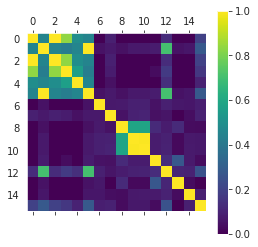

In [38]:
algoritmo = "comunidades_infomap"
cluster = infomap_clusters.sample(1).comunidad.values[0]
nodos_cluster = graph_node_data[graph_node_data[algoritmo] == cluster].node_index.values
plt.matshow(document_similarity_matrix.loc[nodos_cluster,nodos_cluster],vmin=0, vmax=1, cmap="viridis")
plt.grid(False)
plt.colorbar()

mean_sim = infomap_clusters.loc[infomap_clusters.comunidad == cluster, "mean_similarity_mono"].values[0]
print(f"Similaridad media: {mean_sim}")
#display(document_similarity_matrix.loc[nodos_cluster,nodos_cluster])

In [39]:
graph_node_data[graph_node_data[algoritmo] == cluster]

,node_index,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
9445,1059,10880_8535_14217_12532_10996,"telangiectasia, hereditary hemorrhagic,",bert_group,primekg,630.0,13.0,0.0,0.0,5.0
9446,33665,C4551861,"Telangiectasia, Hereditary Hemorrhagic, Type 1",disease,disgenet,630.0,13.0,3.0,0.0,4.0
9447,31937,C3809710,"TELANGIECTASIA, HEREDITARY HEMORRHAGIC, TYPE 5",disease,disgenet,630.0,13.0,1.0,0.0,1.0
9448,27201,C1832529,HEREDITARY HEMORRHAGIC TELANGIECTASIA-RELATED ...,disease,disgenet,630.0,13.0,1.0,0.0,1.0
9449,27560,C1838163,OSLER-RENDU-WEBER SYNDROME 2,disease,disgenet,630.0,13.0,1.0,0.0,1.0
9450,20937,C0039445,Hereditary hemorrhagic telangiectasia,disease,disgenet,630.0,13.0,4.0,0.0,4.0
12257,21867,C0162819,"Skin Diseases, Vascular",disease,disgenet,630.0,13.0,1.0,0.0,26.0
18444,23988,C0345419,Cutis marmorata telangiectatica congenita,disease,disgenet,630.0,13.0,1.0,0.0,2.0
19181,23776,C0340803,Capillary malformation (disorder),disease,disgenet,630.0,13.0,2.0,0.0,7.0
24671,22352,C0235752,Port-Wine Stain,disease,disgenet,630.0,13.0,2.0,0.0,3.0


In [40]:
random_node = np.random.choice(nodos_cluster,1)[0]
most_similar = document_similarity_matrix[random_node].sort_values(ascending=False)[0:10]
graph_node_data.set_index("node_index").loc[most_similar.index.values]

,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
node_index,,,,,,,,,
27201,C1832529,HEREDITARY HEMORRHAGIC TELANGIECTASIA-RELATED ...,disease,disgenet,630.0,13.0,1.0,0.0,1.0
31937,C3809710,"TELANGIECTASIA, HEREDITARY HEMORRHAGIC, TYPE 5",disease,disgenet,630.0,13.0,1.0,0.0,1.0
1059,10880_8535_14217_12532_10996,"telangiectasia, hereditary hemorrhagic,",bert_group,primekg,630.0,13.0,0.0,0.0,5.0
27560,C1838163,OSLER-RENDU-WEBER SYNDROME 2,disease,disgenet,630.0,13.0,1.0,0.0,1.0
27242,C1832942,JUVENILE POLYPOSIS/HEREDITARY HEMORRHAGIC TELA...,disease,disgenet,177.0,14.0,1.0,0.0,1.0
1570,11457_18266,ataxia - telangiectasia variant,bert_group,primekg,637.0,50.0,0.0,0.0,6.0
20937,C0039445,Hereditary hemorrhagic telangiectasia,disease,disgenet,630.0,13.0,4.0,0.0,4.0
33665,C4551861,"Telangiectasia, Hereditary Hemorrhagic, Type 1",disease,disgenet,630.0,13.0,3.0,0.0,4.0
31727,C3714844,"Pulmonary Hypertension, Primary, 1, With Hered...",disease,disgenet,487.0,22.0,7.0,0.0,1.0


## Entropía tfidf de clusters

In [6]:
def load_cluster_matrices(path_infomap:str,path_louvain:str):
    tfidf_infomap = []
    tfidf_louvain = []

    for i in range(3):
        mat_path = f"{path_infomap}matriz_tfidf_infomap_{i}.npz"
        row_path = f"{path_infomap}rows_tfidf_infomap_{i}.txt"
        col_path = f"{path_infomap}cols_tfidf_infomap_{i}.txt"
        
        tfidf_infomap.append(load_sparse_dataframe(mat_path,row_path,col_path))

    for i in range(3):
        mat_path = f"{path_louvain}matriz_tfidf_louvain_{i}.npz"
        row_path = f"{path_louvain}rows_tfidf_louvain_{i}.txt"
        col_path = f"{path_louvain}cols_tfidf_louvain_{i}.txt"
        
        tfidf_louvain.append(load_sparse_dataframe(mat_path,row_path,col_path))
    
    return tfidf_infomap, tfidf_louvain

In [7]:
path_infomap = graph_data + "tfidf_infomap/"
path_louvain = graph_data + "tfidf_louvain/"

tfidf_infomap, tfidf_louvain = load_cluster_matrices(path_infomap,path_louvain)

tfidf_infomap_dense = [mat.sparse.to_dense() for mat in tfidf_infomap]
tfidf_louvain_dense = [mat.sparse.to_dense() for mat in tfidf_louvain]

In [8]:
import scipy.stats
from scipy.stats import entropy
def get_entropy(series,max_normalized=True,normalize_l1=True):
    """Calcula la entropía para una columna de valores de pandas. 
    La extrae como un array y la normaliza para que la suma sea 1 y después calcula la entropía.
    La normalizo por la entropía máxima posible, que sería la distribución uniforme pi=1/(b-a) para valores entre b y a. 
    En este caso es simplemente 1/ el largo del array"""
    values = series.values
    if normalize_l1:
        arr = values/(np.sum(values))
    else:
        arr = values
    if max_normalized:
        max_entropy = entropy(np.ones(len(arr))/len(arr), base=2)
        S = round(entropy(arr, base=2)/max_entropy,2)
    else:
        S = round(entropy(arr, base=2))
    return S

ngrams=1:
S big cluster = 0.53, S small cluster = 0.61


ngrams=2:
S big cluster = 0.53, S small cluster = 0.56


ngrams=3:
S big cluster = 0.5, S small cluster = 0.5




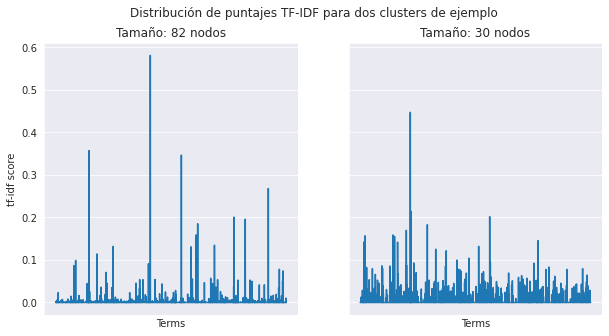

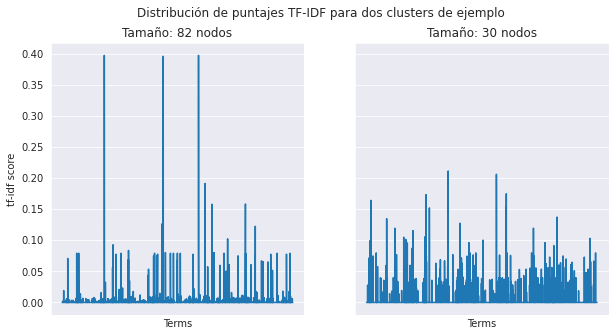

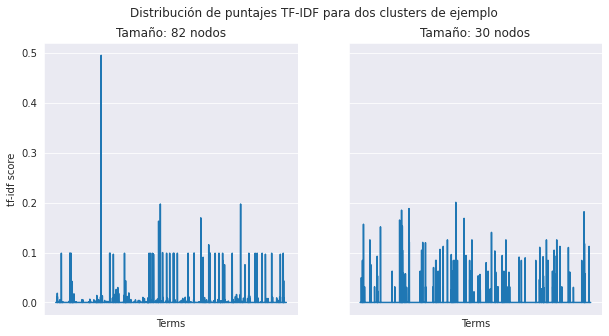

In [9]:
big_cluster = 382
small_cluster = 349

for n in range(3):
    fig, ax = plt.subplots(1,2,figsize=(10,5), sharey=True)
    fig.suptitle("Distribución de puntajes TF-IDF para dos clusters de ejemplo")

    ax[0].set_xticks([])
    ax[0].set_title(f"Tamaño: {tamaños_infomap.loc[big_cluster]} nodos")

    ax[1].set_xticks([])
    ax[1].set_title(f"Tamaño: {tamaños_infomap.loc[small_cluster]} nodos")

    tfidf_infomap_dense[n].loc[big_cluster].plot(ax=ax[0], xlabel='Terms', ylabel='tf-idf score')
    tfidf_infomap_dense[n].loc[small_cluster].plot(ax=ax[1], xlabel='Terms')

    ax[0].grid(True)
    ax[1].grid(True)

    print(f"ngrams={n+1}:\nS big cluster = {get_entropy(tfidf_infomap_dense[n].loc[big_cluster])}, S small cluster = {get_entropy(tfidf_infomap_dense[n].loc[small_cluster])}\n\n")

In [35]:
tfidf_infomap_dense[0].loc[big_cluster].value_counts()

0.000000    7348
0.001045       7
0.000981       6
0.002090       5
0.000936       5
            ... 
0.000522       1
0.004510       1
0.000596       1
0.007957       1
0.010215       1
Name: 382.0, Length: 446, dtype: int64

In [32]:
arr = tfidf_infomap_dense[0].loc[big_cluster].values
arr_norm = arr/np.sum(arr)
arr_max = np.max(arr_norm)
arr_mean = np.mean(arr_norm)
(arr_max/arr_mean)/len(arr)

0.08584533964849163

In [29]:
arr = tfidf_infomap_dense[0].loc[small_cluster].values
arr_max = np.max(arr)
arr_mean = np.mean(arr)
arr_max/arr_mean

276.36789127331826

In [16]:
entropias_infomap = {}
for i,tfidf_matrix in enumerate(tfidf_infomap_dense):
    entropias = [get_entropy(tfidf_matrix.loc[cluster]) for cluster in infomap_clusters.comunidad.values]
    entropias_infomap[i] = np.array(entropias)


entropias_louvain = {}

for i,tfidf_matrix in enumerate(tfidf_louvain_dense):
    entropias = [get_entropy(tfidf_matrix.loc[cluster]) for cluster in louvain_clusters.comunidad.values]
    entropias_louvain[i] = np.array(entropias)

/tmp/ipykernel_5033/336944128.py:10: RuntimeWarning: invalid value encountered in divide
  arr = values/(np.sum(values))


In [18]:
infomap_ids = infomap_clusters.comunidad.values
louvain_ids = louvain_clusters.comunidad.values

series_infomap = []

for i,S in entropias_infomap.items():
    i_series = pd.Series({cluster:S for (cluster,S) in zip(infomap_ids, S)}, name=f"entropia_{i+1}")
    series_infomap.append(i_series)

entropias_infomap_df = pd.DataFrame(series_infomap).T


series_louvain = []

for i,S in entropias_louvain.items():
    i_series = pd.Series({cluster:S for (cluster,S) in zip(louvain_ids, S)}, name=f"entropia_{i+1}")
    series_louvain.append(i_series)

entropias_louvain_df = pd.DataFrame(series_louvain).T

Agrego las entropías al dataframe

In [19]:
infomap_clusters = pd.merge(infomap_clusters, entropias_infomap_df, left_on="comunidad", right_index=True, how="left")
louvain_clusters = pd.merge(louvain_clusters,entropias_louvain_df, left_on="comunidad", right_index=True, how="left")

In [24]:
# infomap_clusters.to_pickle(reports_tfidf+"infomap_analysis_checkpoint.pkl")
# louvain_clusters.to_pickle(reports_tfidf+"louvain_analysis_checkpoint.pkl")

### Calculo entropía de clusters random

In [12]:
def cluster_as_document_random(cluster_id,df,cluster_algorithm):
    cluster_nodes = df.loc[df[cluster_algorithm] == cluster_id].node_index.values
    cluster_corpus = [processed_node_documents[node_index] for node_index in cluster_nodes]
    cluster_document = " ".join(cluster_corpus)
    return cluster_document

In [13]:
disease_attributes_shuffle_columns = disease_attributes[["comunidades_infomap","comunidades_louvain"]]
disease_attributes_shuffle_values = disease_attributes[["node_index","node_id","node_name","mondo_name","mondo_definition","umls_description","orphanet_definition"]]

Iter 0 of 100
Iter 1 of 100
Iter 2 of 100
Iter 3 of 100
Iter 4 of 100
Iter 5 of 100


/tmp/ipykernel_29469/336944128.py:10: RuntimeWarning: invalid value encountered in divide
  arr = values/(np.sum(values))


Iter 6 of 100
Iter 7 of 100
Iter 8 of 100
Iter 9 of 100
Iter 10 of 100
Iter 11 of 100
Iter 12 of 100


/tmp/ipykernel_29469/336944128.py:10: RuntimeWarning: invalid value encountered in divide
  arr = values/(np.sum(values))


Iter 13 of 100
Iter 14 of 100
Iter 15 of 100
Iter 16 of 100
Iter 17 of 100
Iter 18 of 100
Iter 19 of 100
Iter 20 of 100
Iter 21 of 100
Iter 22 of 100
Iter 23 of 100
Iter 24 of 100
Iter 25 of 100
Iter 26 of 100
Iter 27 of 100
Iter 28 of 100
Iter 29 of 100
Iter 30 of 100
Iter 31 of 100
Iter 32 of 100
Iter 33 of 100
Iter 34 of 100
Iter 35 of 100


/tmp/ipykernel_29469/336944128.py:10: RuntimeWarning: invalid value encountered in divide
  arr = values/(np.sum(values))


Iter 36 of 100
Iter 37 of 100
Iter 38 of 100
Iter 39 of 100
Iter 40 of 100
Iter 41 of 100
Iter 42 of 100
Iter 43 of 100
Iter 44 of 100
Iter 45 of 100
Iter 46 of 100
Iter 47 of 100
Iter 48 of 100
Iter 49 of 100
Iter 50 of 100
Iter 51 of 100
Iter 52 of 100
Iter 53 of 100
Iter 54 of 100
Iter 55 of 100
Iter 56 of 100
Iter 57 of 100
Iter 58 of 100
Iter 59 of 100
Iter 60 of 100
Iter 61 of 100
Iter 62 of 100
Iter 63 of 100
Iter 64 of 100
Iter 65 of 100
Iter 66 of 100
Iter 67 of 100
Iter 68 of 100
Iter 69 of 100
Iter 70 of 100
Iter 71 of 100
Iter 72 of 100
Iter 73 of 100
Iter 74 of 100
Iter 75 of 100
Iter 76 of 100
Iter 77 of 100
Iter 78 of 100
Iter 79 of 100
Iter 80 of 100
Iter 81 of 100
Iter 82 of 100
Iter 83 of 100
Iter 84 of 100
Iter 85 of 100
Iter 86 of 100
Iter 87 of 100
Iter 88 of 100
Iter 89 of 100
Iter 90 of 100
Iter 91 of 100
Iter 92 of 100
Iter 93 of 100
Iter 94 of 100
Iter 95 of 100
Iter 96 of 100
Iter 97 of 100
Iter 98 of 100
Iter 99 of 100


/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


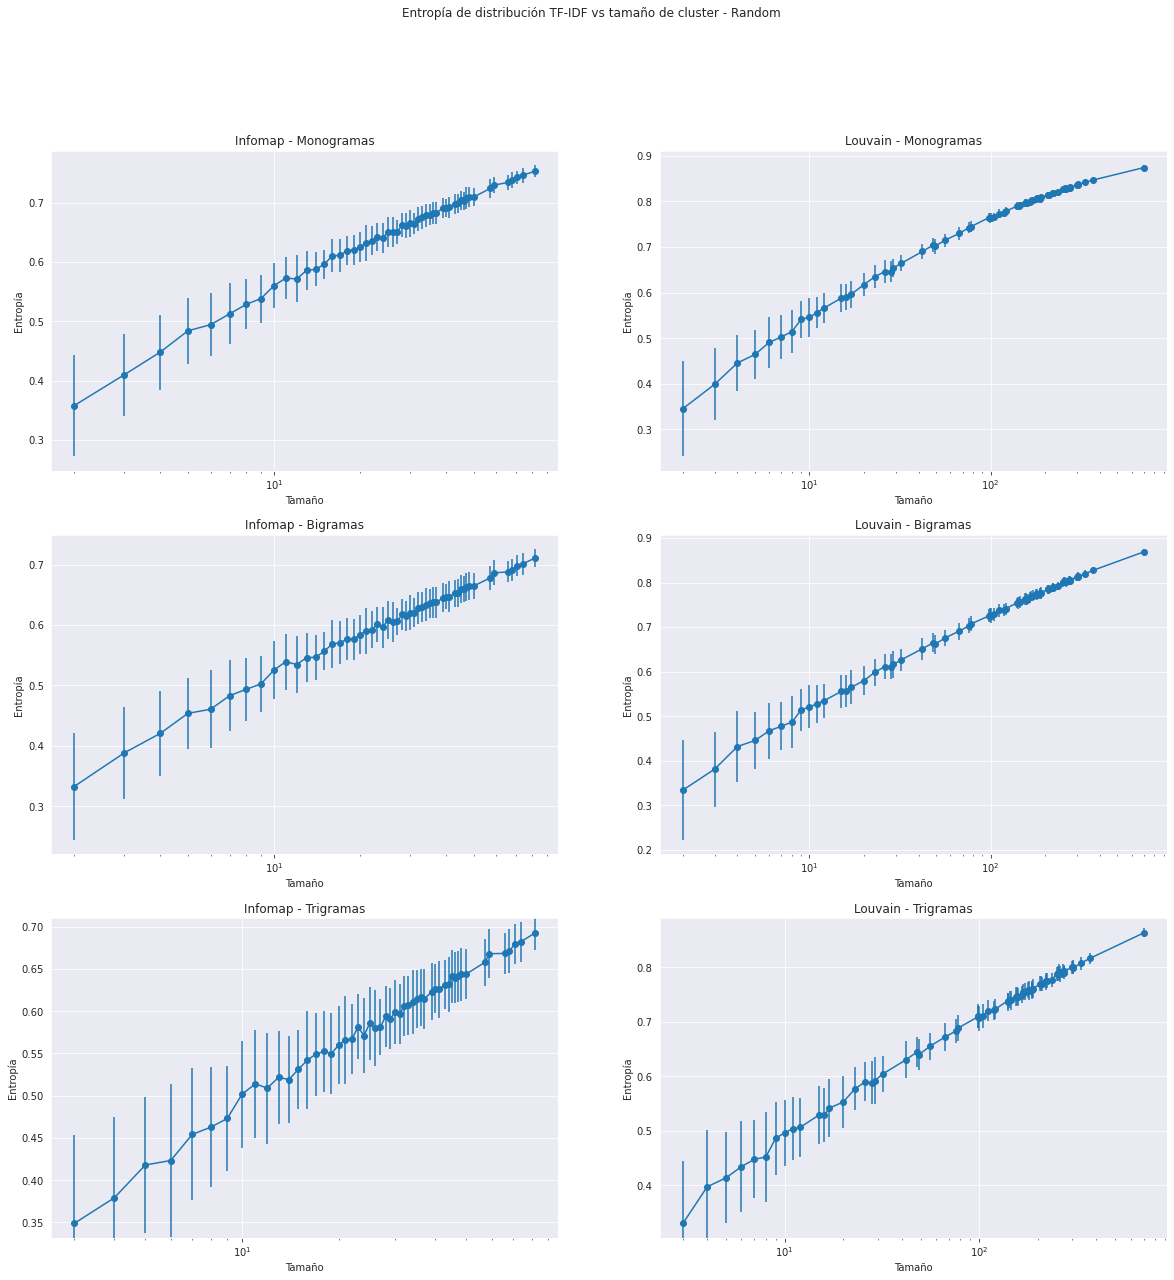

In [14]:
ids_random_infomap = infomap_clusters.drop_duplicates(subset="tamaño").comunidad.values
tamaños_random_infomap = infomap_clusters.set_index("comunidad").loc[ids_random_infomap,"tamaño"].values

ids_random_louvain = louvain_clusters.drop_duplicates(subset="tamaño").comunidad.values
tamaños_random_louvain = louvain_clusters.set_index("comunidad").loc[ids_random_louvain,"tamaño"].values

infomap_ids = infomap_clusters.comunidad.values
louvain_ids = louvain_clusters.comunidad.values

args = {"min_df":3, "max_df":0.3}
vectorizer_mono = TfidfVectorizer(tokenizer = None , stop_words=stop_words, ngram_range=(1,1), min_df=args["min_df"],max_df=args["max_df"])
vectorizer_bi = TfidfVectorizer(tokenizer = None , stop_words=stop_words, ngram_range=(2,2), min_df=args["min_df"],max_df=args["max_df"])
vectorizer_tri = TfidfVectorizer(tokenizer = None , stop_words=stop_words, ngram_range=(3,3), min_df=args["min_df"],max_df=args["max_df"])

iters = 100

results_infomap_mono = []
results_louvain_mono = []

results_infomap_bi = []
results_louvain_bi = []

results_infomap_tri = []
results_louvain_tri = []

for _ in range(iters):
    shuffled_df = pd.merge(disease_attributes_shuffle_values.sample(frac=1).reset_index(drop=True),disease_attributes_shuffle_columns, left_index=True, right_index=True)

    corpus_infomap_random = [cluster_as_document_random(cluster_id,shuffled_df,"comunidades_infomap") for cluster_id in infomap_ids]
    corpus_louvain_random = [cluster_as_document_random(cluster_id,shuffled_df,"comunidades_louvain") for cluster_id in louvain_ids]

    tfidf_infomap_random_mono = get_tfidf_df(vectorizer_mono, corpus_infomap_random,infomap_ids).sparse.to_dense()
    tfidf_louvain_random_mono = get_tfidf_df(vectorizer_mono,corpus_louvain_random,louvain_ids).sparse.to_dense()

    tfidf_infomap_random_bi = get_tfidf_df(vectorizer_bi, corpus_infomap_random,infomap_ids).sparse.to_dense()
    tfidf_louvain_random_bi = get_tfidf_df(vectorizer_bi,corpus_louvain_random,louvain_ids).sparse.to_dense()

    tfidf_infomap_random_tri = get_tfidf_df(vectorizer_tri, corpus_infomap_random,infomap_ids).sparse.to_dense()
    tfidf_louvain_random_tri = get_tfidf_df(vectorizer_tri, corpus_louvain_random,louvain_ids).sparse.to_dense()

    entropias_infomap_random_mono = [get_entropy(tfidf_infomap_random_mono.loc[cluster], normalize_l1 = True) for cluster in ids_random_infomap]
    entropias_louvain_random_mono = [get_entropy(tfidf_louvain_random_mono.loc[cluster], normalize_l1 = True) for cluster in ids_random_louvain]

    entropias_infomap_random_bi = [get_entropy(tfidf_infomap_random_bi.loc[cluster], normalize_l1 = True) for cluster in ids_random_infomap]
    entropias_louvain_random_bi = [get_entropy(tfidf_louvain_random_bi.loc[cluster], normalize_l1 = True) for cluster in ids_random_louvain]

    entropias_infomap_random_tri = [get_entropy(tfidf_infomap_random_tri.loc[cluster], normalize_l1 = True) for cluster in ids_random_infomap]
    entropias_louvain_random_tri = [get_entropy(tfidf_louvain_random_tri.loc[cluster], normalize_l1 = True) for cluster in ids_random_louvain]

    results_infomap_mono.append(entropias_infomap_random_mono)
    results_louvain_mono.append(entropias_louvain_random_mono)

    results_infomap_bi.append(entropias_infomap_random_bi)
    results_louvain_bi.append(entropias_louvain_random_bi)

    results_infomap_tri.append(entropias_infomap_random_tri)
    results_louvain_tri.append(entropias_louvain_random_tri)

    print(f"Iter {_} of {iters}")

means_infomap_mono = [np.mean(arr) for arr in np.array(results_infomap_mono).T]
stds_infomap_mono = [np.std(arr) for arr in np.array(results_infomap_mono).T] 

means_louvain_mono = [np.mean(arr) for arr in np.array(results_louvain_mono).T]
stds_louvain_mono = [np.std(arr) for arr in np.array(results_louvain_mono).T]


means_infomap_bi = [np.mean(arr) for arr in np.array(results_infomap_bi).T]
stds_infomap_bi = [np.std(arr) for arr in np.array(results_infomap_bi).T] 

means_louvain_bi = [np.mean(arr) for arr in np.array(results_louvain_bi).T]
stds_louvain_bi = [np.std(arr) for arr in np.array(results_louvain_bi).T]


means_infomap_tri = [np.mean(arr) for arr in np.array(results_infomap_tri).T]
stds_infomap_tri = [np.std(arr) for arr in np.array(results_infomap_tri).T] 

means_louvain_tri = [np.mean(arr) for arr in np.array(results_louvain_tri).T]
stds_louvain_tri = [np.std(arr) for arr in np.array(results_louvain_tri).T]


fig, ax = plt.subplots(3,2, figsize=(20,20))
fig.suptitle("Entropía de distribución TF-IDF vs tamaño de cluster - Random")
ax[0][0].scatter(tamaños_random_infomap,means_infomap_mono)
ax[0][0].errorbar(tamaños_random_infomap,means_infomap_mono,yerr=stds_infomap_mono)
ax[0][0].set_title("Infomap - Monogramas")
ax[0][0].grid(True)
ax[0][0].set_xlabel("Tamaño")
ax[0][0].set_ylabel("Entropía")
ax[0][0].set_xscale("log")

ax[0][1].scatter(tamaños_random_louvain,means_louvain_mono)
ax[0][1].errorbar(tamaños_random_louvain,means_louvain_mono,yerr=stds_louvain_mono)
ax[0][1].set_xscale("log")
ax[0][1].set_title("Louvain - Monogramas")
ax[0][1].grid(True)
ax[0][1].set_xlabel("Tamaño")
ax[0][1].set_ylabel("Entropía")

ax[1][0].scatter(tamaños_random_infomap,means_infomap_bi)
ax[1][0].errorbar(tamaños_random_infomap,means_infomap_bi,yerr=stds_infomap_bi)
ax[1][0].set_title("Infomap - Bigramas")
ax[1][0].grid(True)
ax[1][0].set_xlabel("Tamaño")
ax[1][0].set_ylabel("Entropía")
ax[1][0].set_xscale("log")

ax[1][1].scatter(tamaños_random_louvain,means_louvain_bi)
ax[1][1].errorbar(tamaños_random_louvain,means_louvain_bi,yerr=stds_louvain_bi)
ax[1][1].set_xscale("log")
ax[1][1].set_title("Louvain - Bigramas")
ax[1][1].grid(True)
ax[1][1].set_xlabel("Tamaño")
ax[1][1].set_ylabel("Entropía")

ax[2][0].scatter(tamaños_random_infomap,means_infomap_tri)
ax[2][0].errorbar(tamaños_random_infomap,means_infomap_tri,yerr=stds_infomap_tri)
ax[2][0].set_title("Infomap - Trigramas")
ax[2][0].grid(True)
ax[2][0].set_xlabel("Tamaño")
ax[2][0].set_ylabel("Entropía")
ax[2][0].set_xscale("log")

ax[2][1].scatter(tamaños_random_louvain,means_louvain_tri)
ax[2][1].errorbar(tamaños_random_louvain,means_louvain_tri,yerr=stds_louvain_tri)
ax[2][1].set_xscale("log")
ax[2][1].set_title("Louvain - Trigramas")
ax[2][1].grid(True)
ax[2][1].set_xlabel("Tamaño")
ax[2][1].set_ylabel("Entropía")


fdict = {"random_louvain_mono":results_louvain_mono, "random_louvain_bi": results_louvain_bi, "random_louvain_tri":results_louvain_tri, "random_infomap_mono":results_infomap_mono, "random_infomap_bi":results_infomap_bi, "random_infomap_tri":results_infomap_tri}

for fname, data in fdict.items():
    arr = np.array(data).T
    np.savetxt(reports_tfidf+"entropia_"+fname+".txt", data)

In [416]:
# fdict = {"random_louvain_mono":results_louvain_mono, "random_louvain_bi": results_louvain_bi, "random_louvain_tri":results_louvain_tri, "random_infomap_mono":results_infomap_mono, "random_infomap_bi":results_infomap_bi, "random_infomap_tri":results_infomap_tri}

# for fname, data in fdict.items():
#     arr = np.array(data).T
#     np.savetxt(reports_tfidf+"entropia_"+fname+".txt", data)

# Top terminos por cluster

In [43]:
def top_ngrams(monogram_matrix,bigram_matrix,trigram_matrix,clusters):
    all_stats = {}
    for cluster in clusters:
        stats = {}
        stats["top_monogram"] = monogram_matrix.loc[cluster].idxmax()
        stats["top_monogram_score"] = round(monogram_matrix.loc[cluster].max(),2)
        stats["top_bigram"] = bigram_matrix.loc[cluster].idxmax()
        stats["top_bigram_score"] = round(bigram_matrix.loc[cluster].max(),2)
        stats["top_trigram"] = trigram_matrix.loc[cluster].idxmax()
        stats["top_trigram_score"] = round(trigram_matrix.loc[cluster].max(),2)
        all_stats[cluster] = stats
    return all_stats

In [44]:
def tuple_cols_to_ngram(df,n):
    old_col = df.columns.values
    if type(old_col[0]) != tuple:
        print("DF in ngram format - skip")
    else:
        if n == 1:
            new_col = [t[0] + " " + t[1] for t in old_col]
        if n == 2:
            new_col = [t[0] + " " + t[1] + " " + t[2] for t in old_col]
        df.columns = new_col

In [45]:
for i in range(2):
    df = tfidf_infomap_dense[i+1]
    tuple_cols_to_ngram(df,i+1)

for i in range(2):
    df = tfidf_louvain_dense[i+1]
    tuple_cols_to_ngram(df,i+1)

DF in ngram format - skip
DF in ngram format - skip
DF in ngram format - skip
DF in ngram format - skip


In [46]:
monograms_infomap = pd.Series({cluster:tfidf_infomap_dense[0].loc[cluster].sort_values(ascending=False)[0:5].index.values.astype(str) for cluster in infomap_ids}, name="top_5_monograms")
monograms_louvain = pd.Series({cluster:tfidf_louvain_dense[0].loc[cluster].sort_values(ascending=False)[0:5].index.values.astype(str) for cluster in louvain_ids}, name="top_5_monograms")

bigrams_infomap = pd.Series({cluster:tfidf_infomap_dense[1].loc[cluster].sort_values(ascending=False)[0:5].index.values.astype(str) for cluster in infomap_ids}, name="top_5_bigrams")
bigrams_louvain = pd.Series({cluster:tfidf_louvain_dense[1].loc[cluster].sort_values(ascending=False)[0:5].index.values.astype(str) for cluster in louvain_ids}, name="top_5_bigrams")

trigrams_infomap = pd.Series({cluster:tfidf_infomap_dense[2].loc[cluster].sort_values(ascending=False)[0:5].index.values.astype(str) for cluster in infomap_ids}, name="top_5_trigrams")
trigrams_louvain = pd.Series({cluster:tfidf_louvain_dense[2].loc[cluster].sort_values(ascending=False)[0:5].index.values.astype(str) for cluster in louvain_ids}, name="top_5_trigrams")

monograms_scores_infomap = pd.Series({cluster:tfidf_infomap_dense[0].loc[cluster].sort_values(ascending=False)[0:5].values for cluster in infomap_ids}, name="top_5_monograms_score").apply(lambda x: np.around(x, decimals=2))
monograms_scores_louvain = pd.Series({cluster:tfidf_louvain_dense[0].loc[cluster].sort_values(ascending=False)[0:5].values for cluster in louvain_ids}, name="top_5_monograms_score").apply(lambda x: np.around(x, decimals=2))

bigrams_scores_infomap = pd.Series({cluster:tfidf_infomap_dense[1].loc[cluster].sort_values(ascending=False)[0:5].values for cluster in infomap_ids}, name="top_5_bigrams_score").apply(lambda x: np.around(x, decimals=2))
bigrams_scores_louvain = pd.Series({cluster:tfidf_louvain_dense[1].loc[cluster].sort_values(ascending=False)[0:5].values for cluster in louvain_ids}, name="top_5_bigrams_score").apply(lambda x: np.around(x, decimals=2))

trigrams_scores_infomap = pd.Series({cluster:tfidf_infomap_dense[2].loc[cluster].sort_values(ascending=False)[0:5].values for cluster in infomap_ids}, name="top_5_trigrams_score").apply(lambda x: np.around(x, decimals=2))
trigrams_scores_louvain = pd.Series({cluster:tfidf_louvain_dense[2].loc[cluster].sort_values(ascending=False)[0:5].values for cluster in louvain_ids}, name="top_5_trigrams_score").apply(lambda x: np.around(x, decimals=2))

top_5_infomap = pd.DataFrame([monograms_infomap, bigrams_infomap, trigrams_infomap, monograms_scores_infomap,bigrams_scores_infomap, trigrams_scores_infomap]).T
top_5_louvain = pd.DataFrame([monograms_louvain, bigrams_louvain, trigrams_louvain, monograms_scores_louvain, bigrams_scores_louvain, trigrams_scores_louvain]).T

infomap_top_ngrams = pd.DataFrame.from_dict(top_ngrams(tfidf_infomap_dense[0],tfidf_infomap_dense[1],tfidf_infomap_dense[2],infomap_ids), orient="index")
louvain_top_ngrams = pd.DataFrame.from_dict(top_ngrams(tfidf_louvain_dense[0],tfidf_louvain_dense[1],tfidf_louvain_dense[2],louvain_ids), orient="index")

infomap_clusters = pd.merge(infomap_clusters, infomap_top_ngrams, how="left",left_on="comunidad", right_index=True)
louvain_clusters = pd.merge(louvain_clusters, louvain_top_ngrams, how="left",left_on="comunidad", right_index=True)

infomap_clusters = pd.merge(infomap_clusters, top_5_infomap, how="left",left_on="comunidad", right_index=True)
louvain_clusters = pd.merge(louvain_clusters, top_5_louvain, how="left",left_on="comunidad", right_index=True)

In [47]:
infomap_clusters

,comunidad,tamaño,top_monogram,top_monogram_score,top_bigram,top_bigram_score,top_trigram,top_trigram_score,top_5_monograms,top_5_bigrams,top_5_trigrams,top_5_monograms_score,top_5_bigrams_score,top_5_trigrams_score
0,382,82,hmsn,0.58,charcot marie,0.40,charcot marie tooth,0.49,"[hmsn, charcot, marie, tooth, refers]","[marie tooth, charcot marie, hmsn refers, moto...","[charcot marie tooth, refers hmsn associate, h...","[0.58, 0.36, 0.35, 0.27, 0.2]","[0.4, 0.4, 0.39, 0.19, 0.16]","[0.49, 0.2, 0.2, 0.17, 0.16]"
1,184,74,epileptic,0.64,epileptic encephalopathy,0.57,infantile epileptic encephalopathy,0.91,"[epileptic, encephalopathy, infantile, seizure...","[epileptic encephalopathy, early infantile, in...","[infantile epileptic encephalopathy, dominant ...","[0.64, 0.52, 0.39, 0.21, 0.13]","[0.57, 0.54, 0.35, 0.32, 0.22]","[0.91, 0.12, 0.1, 0.09, 0.08]"
2,332,74,pigmentosa,0.64,retinitis pigmentosa,0.65,dystrophy retinitis pigmentosa,0.48,"[pigmentosa, retinitis, retinal, dystrophy, ph...","[retinitis pigmentosa, dystrophy retinitis, re...","[dystrophy retinitis pigmentosa, retinal dystr...","[0.64, 0.63, 0.32, 0.26, 0.05]","[0.65, 0.42, 0.36, 0.36, 0.27]","[0.48, 0.47, 0.44, 0.41, 0.41]"
3,353,71,cataract,0.82,lens cataract,0.28,adulthood result degenerative,0.23,"[cataract, lens, congenitally, contrast, degen...","[lens cataract, cataract occurs, cataract occu...","[contrast majority cataract, occur adulthood r...","[0.82, 0.4, 0.21, 0.15, 0.12]","[0.28, 0.24, 0.24, 0.23, 0.23]","[0.23, 0.23, 0.23, 0.23, 0.23]"
4,379,68,paraplegia,0.63,spastic paraplegia,0.63,hereditary spastic paraplegia,0.44,"[paraplegia, spastic, hereditary, spasticity, ...","[spastic paraplegia, hereditary spastic, form ...","[hereditary spastic paraplegia, form hereditar...","[0.63, 0.57, 0.16, 0.12, 0.12]","[0.63, 0.35, 0.2, 0.11, 0.1]","[0.44, 0.3, 0.13, 0.12, 0.12]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143,1091,2,retinal,0.48,idiopathic retinal,0.44,lead retinal detachment,0.70,"[retinal, cd, exudate, telangiectasia, unilate...","[idiopathic retinal, lead retinal, unilateral ...","[lead retinal detachment, affect healthy young...","[0.48, 0.37, 0.27, 0.25, 0.25]","[0.44, 0.29, 0.29, 0.28, 0.26]","[0.7, 0.67, 0.25, 0.0, 0.0]"
1144,891,2,sleep,0.31,sleep disturbance,0.40,short arm chromosome,0.38,"[sleep, deletion, chromosome, disturbance, 17p11]","[sleep disturbance, short arm, cytogenetic ref...","[short arm chromosome, loss short arm, distinc...","[0.31, 0.26, 0.25, 0.24, 0.22]","[0.4, 0.24, 0.22, 0.21, 0.19]","[0.38, 0.33, 0.22, 0.17, 0.17]"
1145,1140,2,triphalangeal,0.52,triphalangeal thumb,0.72,rare genetic dysostosis,0.73,"[triphalangeal, thumb, polysyndactyly, tibia, ...","[triphalangeal thumb, tibial hemimelia, absent...","[rare genetic dysostosis, radio ulnar synostos...","[0.52, 0.37, 0.32, 0.27, 0.17]","[0.72, 0.25, 0.25, 0.25, 0.25]","[0.73, 0.68, 0.0, 0.0, 0.0]"
1146,889,2,laxa,0.42,cutis laxa,0.42,connective tissue skin,0.33,"[laxa, cutis, cl, inelastic, acquire]","[cutis laxa, wrinkle redundant, connective tis...","[connective tissue skin, cutis laxa cl, inelas...","[0.42, 0.37, 0.3, 0.24, 0.24]","[0.42, 0.24, 0.17, 0.17, 0.17]","[0.33, 0.33, 0.33, 0.32, 0.32]"


### Checkpoint

In [127]:
# infomap_clusters.to_pickle(reports_tfidf+"infomap_analysis_checkpoint.pkl")
# louvain_clusters.to_pickle(reports_tfidf+"louvain_analysis_checkpoint.pkl")

In [48]:
display(infomap_clusters.head())
display(louvain_clusters.head())

,comunidad,tamaño,top_monogram,top_monogram_score,top_bigram,top_bigram_score,top_trigram,top_trigram_score,top_5_monograms,top_5_bigrams,top_5_trigrams,top_5_monograms_score,top_5_bigrams_score,top_5_trigrams_score
0,382,82,hmsn,0.58,charcot marie,0.40,charcot marie tooth,0.49,"[hmsn, charcot, marie, tooth, refers]","[marie tooth, charcot marie, hmsn refers, moto...","[charcot marie tooth, refers hmsn associate, h...","[0.58, 0.36, 0.35, 0.27, 0.2]","[0.4, 0.4, 0.39, 0.19, 0.16]","[0.49, 0.2, 0.2, 0.17, 0.16]"
1,184,74,epileptic,0.64,epileptic encephalopathy,0.57,infantile epileptic encephalopathy,0.91,"[epileptic, encephalopathy, infantile, seizure...","[epileptic encephalopathy, early infantile, in...","[infantile epileptic encephalopathy, dominant ...","[0.64, 0.52, 0.39, 0.21, 0.13]","[0.57, 0.54, 0.35, 0.32, 0.22]","[0.91, 0.12, 0.1, 0.09, 0.08]"
2,332,74,pigmentosa,0.64,retinitis pigmentosa,0.65,dystrophy retinitis pigmentosa,0.48,"[pigmentosa, retinitis, retinal, dystrophy, ph...","[retinitis pigmentosa, dystrophy retinitis, re...","[dystrophy retinitis pigmentosa, retinal dystr...","[0.64, 0.63, 0.32, 0.26, 0.05]","[0.65, 0.42, 0.36, 0.36, 0.27]","[0.48, 0.47, 0.44, 0.41, 0.41]"
3,353,71,cataract,0.82,lens cataract,0.28,adulthood result degenerative,0.23,"[cataract, lens, congenitally, contrast, degen...","[lens cataract, cataract occurs, cataract occu...","[contrast majority cataract, occur adulthood r...","[0.82, 0.4, 0.21, 0.15, 0.12]","[0.28, 0.24, 0.24, 0.23, 0.23]","[0.23, 0.23, 0.23, 0.23, 0.23]"
4,379,68,paraplegia,0.63,spastic paraplegia,0.63,hereditary spastic paraplegia,0.44,"[paraplegia, spastic, hereditary, spasticity, ...","[spastic paraplegia, hereditary spastic, form ...","[hereditary spastic paraplegia, form hereditar...","[0.63, 0.57, 0.16, 0.12, 0.12]","[0.63, 0.35, 0.2, 0.11, 0.1]","[0.44, 0.3, 0.13, 0.12, 0.12]"


,comunidad,tamaño,top_monogram,top_monogram_score,top_bigram,top_bigram_score,top_trigram,top_trigram_score,top_5_monograms,top_5_bigrams,top_5_trigrams,top_5_monograms_score,top_5_bigrams_score,top_5_trigrams_score
0,3,702,carcinoma,0.57,cell carcinoma,0.51,squamous cell carcinoma,0.61,"[carcinoma, cell, malignant, adenocarcinoma, n...","[cell carcinoma, squamous cell, malignant neop...","[squamous cell carcinoma, renal cell carcinoma...","[0.57, 0.4, 0.26, 0.23, 0.23]","[0.51, 0.32, 0.29, 0.21, 0.17]","[0.61, 0.26, 0.24, 0.24, 0.18]"
1,18,369,skin,0.47,palmoplantar keratoderma,0.47,diffuse palmoplantar keratoderma,0.24,"[skin, palmoplantar, keratoderma, hair, sol]","[palmoplantar keratoderma, palm sol, ectoderma...","[diffuse palmoplantar keratoderma, skin mucous...","[0.47, 0.29, 0.27, 0.26, 0.18]","[0.47, 0.31, 0.23, 0.2, 0.11]","[0.24, 0.23, 0.12, 0.11, 0.1]"
2,16,333,inflammation,0.34,small intestine,0.31,non neoplastic neoplastic,0.19,"[inflammation, esophagus, intestine, intestina...","[small intestine, gastrointestinal tract, muco...","[non neoplastic neoplastic, neoplastic neoplas...","[0.34, 0.24, 0.24, 0.2, 0.17]","[0.31, 0.2, 0.18, 0.17, 0.17]","[0.19, 0.19, 0.18, 0.17, 0.16]"
3,33,304,infection,0.60,infection cause,0.32,inflammation joint cause,0.18,"[infection, virus, fever, bacteria, joint]","[infection cause, bacterial infection, infecti...","[inflammation joint cause, brain spinal cord, ...","[0.6, 0.27, 0.2, 0.17, 0.16]","[0.32, 0.16, 0.12, 0.11, 0.11]","[0.18, 0.14, 0.14, 0.14, 0.14]"
4,14,304,parathyroid,0.40,parathyroid hormone,0.49,chronic mucocutaneous candidiasis,0.18,"[parathyroid, vitamin, bone, rickets, hormone]","[parathyroid hormone, hypocalcemia hyperphosph...","[chronic mucocutaneous candidiasis, renal phos...","[0.4, 0.33, 0.28, 0.27, 0.21]","[0.49, 0.17, 0.16, 0.13, 0.13]","[0.18, 0.18, 0.14, 0.13, 0.13]"


# Regiones de entropía

In [129]:
def regiones_entropia(df,cortes,nsamples):
    region1 = df[df.entropia_1 <= cortes[0]].sample(nsamples)
    region2 = df[(df.entropia_1 > cortes[0]) & (df.entropia_1 <= cortes[1])].sample(nsamples)
    region3 = df[df.entropia_1> cortes[1]].sample(nsamples)
    return [region1,region2,region3]

In [194]:
ejemplos_infomap = regiones_entropia(infomap_clusters, (0.3,0.6), 3)
ejemplos_louvain = regiones_entropia(louvain_clusters,(0.3,0.6), 3)

In [199]:
ejemplos_infomap[2]

,comunidad,tamaño,entropia_1,entropia_2,entropia_3,top_monogram,top_monogram_score,top_bigram,top_bigram_score,top_trigram,top_trigram_score,top_5_monograms,top_5_bigrams,top_5_trigrams,top_5_monograms_score,top_5_bigrams_score,top_5_trigrams_score
262,148,14,0.61,0.59,0.57,meningitis,0.41,spinal cord,0.38,brain spinal cord,0.50,"[meningitis, infection, inflammation, spinal, ...","[spinal cord, brain spinal, inflammation menin...","[brain spinal cord, surround brain spinal, inf...","[0.41, 0.38, 0.29, 0.28, 0.25]","[0.38, 0.33, 0.27, 0.2, 0.2]","[0.5, 0.32, 0.25, 0.25, 0.16]"
65,304,26,0.72,0.65,0.60,papule,0.24,function skin,0.14,characteristic set symptom,0.14,"[papule, lesion, erythema, plaque, multiforme]","[function skin, skin affect, chronic infection...","[characteristic set symptom, structure functio...","[0.24, 0.17, 0.17, 0.15, 0.15]","[0.14, 0.1, 0.1, 0.09, 0.09]","[0.14, 0.14, 0.14, 0.14, 0.14]"
198,521,16,0.62,0.55,0.54,dysplasia,0.40,long bone,0.42,bow long bone,0.38,"[dysplasia, bone, bow, long, hypocalcemia]","[long bone, skeletal dysplasia, dysplasia char...","[bow long bone, skeletal dysplasia characteriz...","[0.4, 0.38, 0.24, 0.21, 0.18]","[0.42, 0.22, 0.22, 0.19, 0.19]","[0.38, 0.27, 0.2, 0.19, 0.18]"


In [196]:
ejemplos = ejemplos_infomap[0]

In [197]:
for comunidad in ejemplos.comunidad.values:
    fig = px.bar(tfidf_infomap_dense[0].loc[comunidad].sort_values(ascending=False)[0:10],width=800, height=400, title="Distribución de valor TF-IDF para monogramas")
    fig.show()